# Aligning HST images to an absolute reference catalog
***

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, 'DrizzlePac' or 'Astroquery'.</div>

<div class="alert-warning">Note: This notebook is based on WFC3 ISR 2017-19: <a href="http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2017-19.pdf">Aligning HST Images to Gaia: a Faster Mosaicking Workflow</a> and contains a subset of the information/code found in <a href="https://github.com/spacetelescope/gaia_alignment">the repository here</a>.  For more information, see the notebook in that repository titled 'Gaia_alignment.ipynb'.</div>

## Introduction

The alignment of HST exposures is a critical step in image stacking/combination performed by software such as `AstroDrizzle`.  Generally, a relative alignment is performed that aligns one image (or multiple images) to another image which is designated as the reference image.  This makes it so the images are aligned to each other, but the pointing error of the observatory can still cause the images to have incorrect absolute astrometry.

When absolute astrometry is desired, the images can be aligned to an external catalog that is known to be on an absolute frame.  In this example, we will provide a workflow to query catalogs such as SDSS and Gaia via the astroquery package, and then align the images to that catalog via TweakReg.

For more information about TweakReg, see the other notebooks in this repository or the __[TweakReg Documentation](https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html)__.

For more information on Astroquery, see the other notebooks in this repository or the __[Astroquery Documentation](https://astroquery.readthedocs.io/en/latest/)__.

In [1]:
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from astroquery.sdss import SDSS

#from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Set up the data

In [2]:
import tr14_headers as TH

In [3]:
from importlib import reload
reload(TH)

<module 'tr14_headers' from '/user/jaguilar/tr14/code/tr14_headers.py'>

In [4]:
prihdrs = TH.load_headers('pri')
scihdrs = TH.load_headers('sci')

In [5]:
# TH.print_columns(prihdrs)
gb_filter = prihdrs.groupby('FILTER')
gb_filter

In [6]:
TH.print_columns(prihdrs)

ANG_SIDE
APERTURE
ASN_ID
ASN_MTYP
ASN_TAB
ATODGNA
ATODGNB
ATODGNC
ATODGND
ATODTAB
BADINPDQ
BIACFILE
BIASFILE
BIASLEVA
BIASLEVB
BIASLEVC
BIASLEVD
BITPIX
BLEVCORR
BPIXTAB
CAL_VER
CCDAMP
CCDGAIN
CCDOFSAB
CCDOFSCD
CCDTAB
COMPTAB
CRCORR
CRDS_CTX
CRDS_VER
CRMASK
CRRADIUS
CRREJTAB
CRSIGMAS
CRTHRESH
CSMID
CSYS_VER
D2IMFILE
DARKCORR
DARKFILE
DATE
DATE-OBS
DEC_TARG
DETECTOR
DFLTFILE
DGEOFILE
DIRIMAGE
DISTNAME
DQICORR
DRIZCORR
DRKCFILE
DWELL_LN
DWELL_TM
EQUINOX
EXPEND
EXPFLAG
EXPSTART
EXPTIME
EXTEND
FGSLOCK
FILENAME
FILETYPE
FILTER
FLATCORR
FLSHFILE
GRAPHTAB
GYROMODE
IDCTAB
IMAGETYP
IMPHTTAB
INITGUES
INSTRUME
LFLTFILE
LINENUM
MDRIZTAB
MEANEXP
MOONANGL
MTFLAG
NAXIS
NEXTEND
NLINCORR
NLINFILE
NO_LINES
NPOLFILE
NRPTEXP
NSAMP
OBSMODE
OBSTYPE
OPUS_VER
ORIGIN
OSCNTAB
P1_ANGLE
P1_CENTR
P1_FRAME
P1_LSPAC
P1_NPTS
P1_ORINT
P1_PSPAC
P1_PURPS
P1_SHAPE
PATTERN1
PATTSTEP
PA_V3
PCTETAB
PFLTFILE
PHOTBW
PHOTCORR
PHOTFLAM
PHOTFNU
PHOTMODE
PHOTPLAM
PHOTZPT
POSTARG1
POSTARG2
PRIMESI
PROCTIME
PROPAPER
PROPOSID
PR_INV_

In [7]:
# re-download the data from MAST, following the example
proposids = prihdrs['PROPOSID'].unique()
filters = prihdrs['FILTER'].unique()
prihdrs.query(f"PROPOSID == {proposids[0]}")

,SIMPLE,BITPIX,NAXIS,EXTEND,ORIGIN,DATE,NEXTEND,FILENAME,FILETYPE,TELESCOP,...,FLSHFILE,PCTETAB,SNKCFILE,UPWCSVER,PYWCSVER,NPOLFILE,IDCTAB,D2IMFILE,SIPNAME,DISTNAME
0,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct01i5q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct01i5q_w3m18525i,icct01i5q_w3m18525i-NOMODEL-NOMODEL
3,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct02jxq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct02jxq_w3m18525i,icct02jxq_w3m18525i-NOMODEL-NOMODEL
4,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,14,icct04omq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04omq_w3m18525i,icct04omq_w3m18525i-NOMODEL-NOMODEL
5,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p1q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p1q_w3m18525i,icct04p1q_w3m18525i-NOMODEL-NOMODEL
6,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,14,icct02jiq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct02jiq_w3m18525i,icct02jiq_w3m18525i-NOMODEL-NOMODEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04oxq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04oxq_w3m18525i,icct04oxq_w3m18525i-NOMODEL-NOMODEL
178,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p0q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p0q_w3m18525i,icct04p0q_w3m18525i-NOMODEL-NOMODEL
179,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct01iaq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct01iaq_w3m18525i,icct01iaq_w3m18525i-NOMODEL-NOMODEL
180,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p7q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p7q_w3m18525i,icct04p7q_w3m18525i-NOMODEL-NOMODEL


In [8]:
# # Get the observation records
# obsTable = Observations.query_criteria(obs_id='icct01*', proposal_id=proposids[0], obstype='all', filters=filters[0])

# # Get the listing of data products
# products = Observations.get_product_list(obsTable)

# # Filter the products for exposures
# filtered_products = Observations.filter_products(products, productSubGroupDescription='FLT')

# # Show the table
# filtered_products

In [9]:
# # # Download all the images above
# Observations.download_products(filtered_products, mrp_only=False)

In [10]:
# # For convenience, move the products into the current directory.
# for flc in glob.glob('./mastDownload/HST/*/*flt.fits'):
#     flc_name = os.path.split(flc)[-1]
#     os.rename(flc, flc_name)

### Inspect the image header

The cell below shows how to query information from the image header using `ImageFileCollection` in `ccdproc`. 
We see that the 1st exposure is 30 seconds and the 2nd and 3rd exposures are 360 seconds. The 3rd exposure is dithered by ~82" in the Y-direction which is approximately the width of one UVIS chip. 

In [11]:
# collec = ImageFileCollection('./', glob_include="*flc.fits", ext=0,
#                              keywords=["targname", "ra_targ", "dec_targ", "filter", "exptime", "postarg1", "postarg2"])

# table = collec.summary
# table['exptime'].format = '7.1f'
# table['ra_targ'].format = '7.7f'
# table['dec_targ'].format = '7.7f'
# table['postarg1'].format = '7.2f'
# table['postarg2'].format = '7.2f'
# table

# 2. Querying catalogs

Now that we have the images, we will download the reference catalogs from both SDSS and Gaia using `astroquery`.

In [12]:
# import ccdproc

### 2a. Identify Coordinates
We will first create a SkyCoord Object to point astroquery to where we are looking on the sky.  Since our example uses data from NGC 6791, we will use the `ra_targ` and `dec_targ` keywords from the first image to get the coordinates of the object.

In [13]:
RA, Dec = prihdrs[['RA_TARG','DEC_TARG']].mean()

In [14]:
# RA = table['ra_targ'][0]
# Dec = table['dec_targ'][0]

### 2b. SDSS Query
We now give those values to an astropy `SkyCoord` object, which we will pass to the SDSS.  Additionally, we use an astropy `Quantity` object to create a radius for the SDSS query.  We set the radius to 6 arcminutes to comfortably cover the area of our images. For reference UVIS detector field of view is ~2.7'x2.7' and a y-dither of 82" covers a total area on the sky of ~2.7'x4.1'.

In [15]:
coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(6., u.arcmin)

Then we only need to perform the query via the `SDSS.query_region` method of `astroquery.sdss`. The `spectro=False` keyword argument means we want to exclude spectroscopic objects, as we are looking for objects to match with an image.  

In the fields parameter, we specify a list of fields we want returned by the query.  In this case we only need the position, and maybe a magnitude 'g' if we want to cut very dim and/or bright objects out of the catalog, as those are likely measured poorly. Details on selecting objects by magnitude may be found in the original ['Gaia_alignment' notebook](https://github.com/spacetelescope/gaia_alignment).  Many other fields are available in the SDSS query and are [documented here](http://cas.sdss.org/dr7/en/help/browser/description.asp?n=PhotoObj&t=V).

### 2c. Gaia Query
Similarly to SDSS, we can query Gaia catalogs for our target via `astroquery.gaia`.  We can use the same `coord` and  `radius` from the SDSS query.

In [16]:
gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
gaia_query

INFO: Query finished. [astroquery.utils.tap.core]


solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object,float64
1635721458409799680,Gaia DR2 5350363807162597120,5350363807162597120,872774637,2015.5,160.97658959010133,0.3365367713567268,-59.55249098182289,0.5359762944092921,0.8733720941089513,0.570336928617211,1.5313265,-7.576554319260021,1.3728263698855137,6.801937455810753,1.4254079927418715,-0.49423218,0.56721884,-0.30539086,0.46292046,-0.7448693,0.49659374,-0.6913826,-0.31673318,0.60329133,-0.76882905,98,0,98,0,8.656539,266.71506,1.5855562472222249,11.415050326483556,31,False,0.24230614,1.3966305627734596,0.08398083392477768,0.14143619,11,7,1.6897193,0,18,False,121,1095.1866439909002,12.487370361394136,87.703545,18.089645,0,--,--,--,--,0,--,--,--,--,--,2,--,--,--,--,--,0,--,--,--,NOT_AVAILABLE,287.40620919083364,-0.5811653178726762,201.77511694445386,-58.94352268928641,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+5350363807162597120,,0.00025705117541941473
1635721458409799680,Gaia DR2 5350363807162600960,5350363807162600960,554132495,2015.5,160.9752749195771,0.23666025265549182,-59.55202940440821,0.18440279832755127,0.17859675545616702,0.2491473844034287,0.71683174,-6.865730232402158,0.49731530144695957,3.4834446552511324,0.40934003575809114,-0.40203255,-0.4906559,-0.48389843,0.22686647,

This query has returned very large number of columns. We want to pare down the catalog to make it easier to use with `TweakReg`.  
We can select only the useful columns via:

In [17]:
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query

ra,dec,phot_g_mean_mag
deg,deg,mag
float64,float64,float32
160.97658959010133,-59.55249098182289,18.089645
160.9752749195771,-59.55202940440821,17.514658
160.97760872431365,-59.552586158621004,15.9538765
160.97701694527396,-59.55160150571137,17.963804
160.97778474503897,-59.55185848300624,16.565895
160.9774709254362,-59.5529562939828,18.166225
160.97684489019733,-59.55318451232135,19.178091
160.97640633484784,-59.55084134204515,13.717369


Then we write this catalog to an ascii file for use with `TweakReg`.

In [18]:
reduced_query.write('gaia.cat', format='ascii.commented_header')

## 3. Running TweakReg
With the catalogs downloaded and the headers populated, we simply need to run TweakReg with each catalog passed into the `refcat` parameter. The steps below compare the astrometric residuals obtained from aligning to each `refcat`. In each test case, we set `updatehdr` to False until we are satisfied with the alignment by inspecting both the shift file and the astrometric residual plots.

As we can see, the RMS is fairly large at about 0.5 pixels, which is not a great fit. This is likely because the SDSS astrometric precision is not high enough to get good HST alignment. One approach would be to align the first image to SDSS and then align the remaining HST images to one another. This would improve both the absolute and relative alignment of the individual frames.

### 3b. Gaia Alignment

In [19]:
from pathlib import Path
# [(Path("../data/tr14/") / i).as_posix() 
#  for i in gb_filter.get_group(filters[0])['FILENAME']]

In [27]:
list_of_images = [(Path("../data/tr14/") / i).as_posix() 
                  #for i in gb_filter.get_group(filters[0]).query('SUBARRAY == False')['FILENAME']]
                  for i in prihdrs.query('SUBARRAY == False')['FILENAME']]
len(list_of_images)

54

In [28]:
import matplotlib as mpl

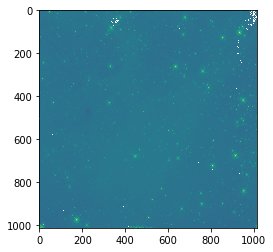

In [29]:
hdulist = fits.open(list_of_images[0])
data = hdulist[1].data
fig, ax = plt.subplots(1,1)
ax.imshow(data, norm=mpl.colors.LogNorm())
hdulist.close()

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 11:38:59.312 (28/04/2020) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
numpy Version -> 1.18.1 
astropy Version -> 4.0.1.post1 
stwcs Version -> 1.5.3 

Finding shifts for: 
    /user/jaguilar/tr14/data/tr14/icct02jfq_flt.fits
    /user/jaguilar/tr14/data/tr14/icct02jdq_flt.fits
    /user/jaguilar/tr14/data/tr14/icct02jcq_flt.fits
    /user/jaguilar/tr14/data/tr14/icog02rzq_flt.fits
    /user/jaguilar/tr14/data/tr14/icog02rsq_flt.fits
    /user/jaguilar/tr14/data/tr14/icct01hrq_flt.fits
    /user/jaguilar/tr14/data/tr14/icct02jeq_flt.fits
    /user/jaguilar/tr14/data/tr14/icog02rpq_flt.fits
    /user/jaguilar/tr14/data/tr14/icct01hqq_flt.fits
    /user/jaguilar/tr14/data/tr14/icct03lqq_flt.fits
    /user/jaguilar/tr14/data/tr14/icct03lnq_flt.fits
    /user/jaguilar/tr14/data

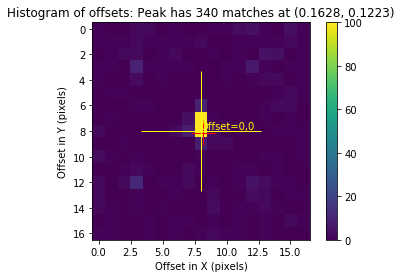

Found 463 matches for /user/jaguilar/tr14/data/tr14/icct02jfq_flt.fits...
Computed  rscale  fit for  /user/jaguilar/tr14/data/tr14/icct02jfq_flt.fits : 
XSH: -0.3068  YSH: -0.4813    ROT: 0.01456268786    SCALE: 1.000094
FIT XRMS: 0.064      FIT YRMS: 0.056  
FIT RMSE: 0.085      FIT MAE: 0.077  

RMS_RA: 4.7e-06 (deg)   RMS_DEC: 1.9e-06 (deg)

Final solution based on  435  objects.
wrote XY data to:  icct02jfq_flt_catalog_fit.match
Total # points: 435
# of points after clipping: 435
Total # points: 435
# of points after clipping: 435


Press ENTER for next image, 
      'n' to continue without updating header or 
      'q' to quit immediately...
 



Performing fit for: /user/jaguilar/tr14/data/tr14/icct02jdq_flt.fits

Matching sources from '/user/jaguilar/tr14/data/tr14/icct02jdq_flt.fits' with sources from reference catalog 'gaia.cat'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0.2567, -0.2234 with significance of 157.4 and 504 matches


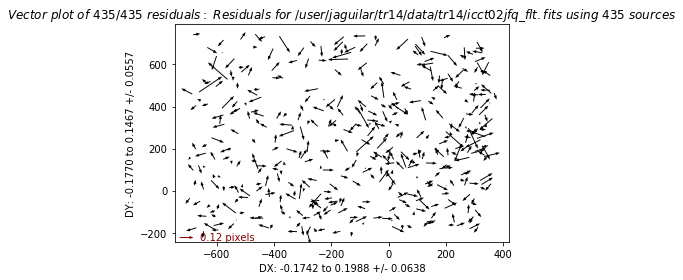

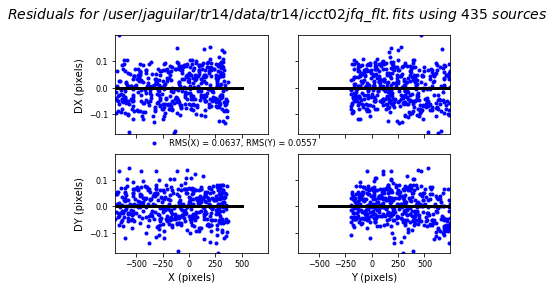

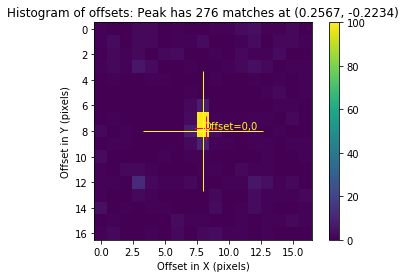

Found 464 matches for /user/jaguilar/tr14/data/tr14/icct02jdq_flt.fits...
Computed  rscale  fit for  /user/jaguilar/tr14/data/tr14/icct02jdq_flt.fits : 
XSH: -0.3026  YSH: -0.5702    ROT: 0.01485017279    SCALE: 1.000097
FIT XRMS: 0.065      FIT YRMS: 0.058  
FIT RMSE: 0.087      FIT MAE: 0.079  

RMS_RA: 4.8e-06 (deg)   RMS_DEC: 1.9e-06 (deg)

Final solution based on  438  objects.
wrote XY data to:  icct02jdq_flt_catalog_fit.match
Total # points: 438
# of points after clipping: 438
Total # points: 438
# of points after clipping: 438


Press ENTER for next image, 
      'n' to continue without updating header or 
      'q' to quit immediately...
 



Performing fit for: /user/jaguilar/tr14/data/tr14/icct02jcq_flt.fits

Matching sources from '/user/jaguilar/tr14/data/tr14/icct02jcq_flt.fits' with sources from reference catalog 'gaia.cat'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0.4029, 0.09103 with significance of 252.7 and 503 matches


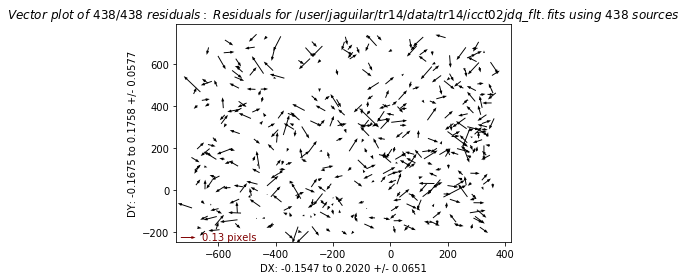

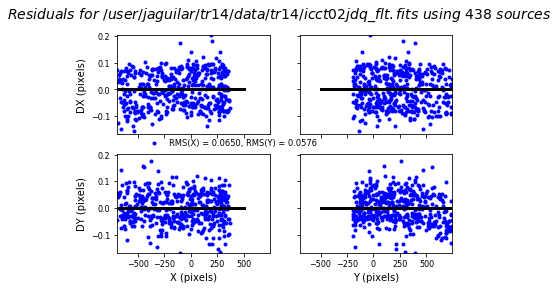

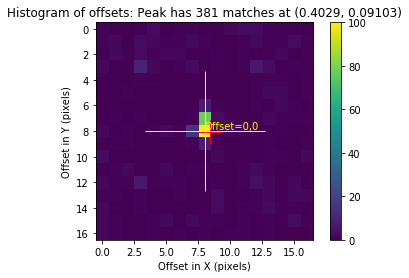

Found 444 matches for /user/jaguilar/tr14/data/tr14/icct02jcq_flt.fits...
Computed  rscale  fit for  /user/jaguilar/tr14/data/tr14/icct02jcq_flt.fits : 
XSH: -0.3150  YSH: -0.4379    ROT: 0.01418550456    SCALE: 1.000085
FIT XRMS: 0.066      FIT YRMS: 0.057  
FIT RMSE: 0.087      FIT MAE: 0.079  

RMS_RA: 4.8e-06 (deg)   RMS_DEC: 1.9e-06 (deg)

Final solution based on  424  objects.
wrote XY data to:  icct02jcq_flt_catalog_fit.match
Total # points: 424
# of points after clipping: 424
Total # points: 424
# of points after clipping: 424


Press ENTER for next image, 
      'n' to continue without updating header or 
      'q' to quit immediately...
 



Performing fit for: /user/jaguilar/tr14/data/tr14/icog02rzq_flt.fits

Matching sources from '/user/jaguilar/tr14/data/tr14/icog02rzq_flt.fits' with sources from reference catalog 'gaia.cat'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0.4069, 0.4394 with significance of 338.5 and 510 matches


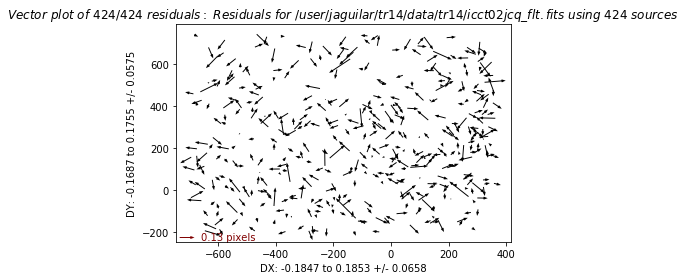

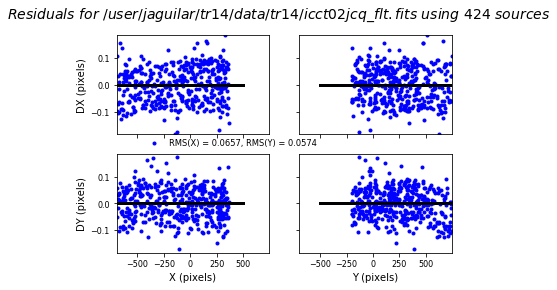

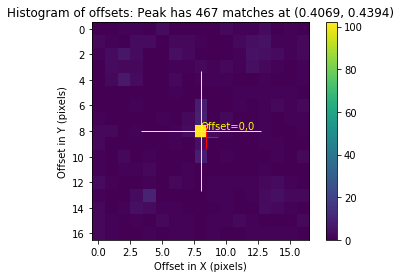

Found 467 matches for /user/jaguilar/tr14/data/tr14/icog02rzq_flt.fits...
Computed  rscale  fit for  /user/jaguilar/tr14/data/tr14/icog02rzq_flt.fits : 
XSH: 0.0153  YSH: -0.0781    ROT: 0.008657394573    SCALE: 1.000285
FIT XRMS: 0.075      FIT YRMS: 0.068  
FIT RMSE: 0.1        FIT MAE: 0.09   

RMS_RA: 5.7e-06 (deg)   RMS_DEC: 2.2e-06 (deg)

Final solution based on  447  objects.
wrote XY data to:  icog02rzq_flt_catalog_fit.match
Total # points: 447
# of points after clipping: 447
Total # points: 447
# of points after clipping: 447


In [ ]:
refcat = 'gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment

# tweakreg.TweakReg(list_of_images[0],#'*flc.fits',  # Pass input images
#                   updatehdr=False,  # update header with new WCS solution
#                   imagefindcfg={'threshold':500.,'conv_width':cw},  # Detection parameters, threshold varies for different data
#                   refcat=refcat,  # Use user supplied catalog (Gaia)
#                   interactive=False,
#                   see2dplot=False,
#                   shiftfile=True,  # Save out shift file (so we can look at shifts later)
#                   outshifts='Gaia_shifts.txt',  # name of the shift file
#                   wcsname=wcsname,  # Give our WCS a new name
#                   reusename=True,
#                   sigma=2.3,
#                   ylimit=0.2,
#                   fitgeometry='general')  # Use the 6 parameter fit
#%pdb 0
#%debug -b /Users/jaguilar/miniconda3/envs/orbitize/lib/python3.6/site-packages/drizzlepac/imgclasses.py:1604
reload(tweakreg)
tweakreg.TweakReg(list_of_images,
                  refcat=refcat)

We can similarly look at the shift file from alignment to the Gaia catalog:

In [ ]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

In [ ]:
# Astrometric residual plots
Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

In [ ]:
Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

In [ ]:
Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As expected, the Gaia catalog does quite a bit better, with rms residuals less tha 0.05 pixels.  

To apply these transformations to the image, we simply need to run TweakReg the same as before, but set the parameter `updatehdr` equal to `True`:

In [ ]:
refcat = 'gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold': 500., 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  fitgeometry='general')  # Use the 6 parameter fit

## 4. Drizzle the Data

While the three sets of FLC files are now aligned, we drizzle together only the two long exposures. 

When exposures are very different lengths, drizzling them together doesn't work well when 'EXP' weighting is used. For objects that saturate in the long exposures, the problem occurs at the boundary where you transition from only short exposure to short plus long. Here the pixels getting power from long exposure pixels are only getting power from pixels whose centers are outside the ring, and thus they are weighted lower than they would be if they were getting values from both inside and outside the ring. The result is a discontinuity in the PSF radial profile and a resulting flux which is too low in those boundary pixels. For photometry of saturated objects, the short exposures should be drizzled separately from the long exposures. 

In [ ]:
astrodrizzle.AstroDrizzle('ibwb01x[rx]q_flc.fits', 
                          output='f606w',
                          preserve=False,
                          clean=True, 
                          build=False,
                          context=False,
                          skymethod='match',
                          driz_sep_bits='64, 32',
                          combine_type='minmed',
                          final_bits='64, 32')

In [ ]:
# Display the combined science and weight images 

sci = fits.getdata('f606w_drc_sci.fits')
wht = fits.getdata('f606w_drc_wht.fits')

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')
ax2.imshow(wht, vmin=0, vmax=1000, cmap='Greys_r', origin='lower')

## Conclusions

Many other services have interfaces for querying catalogs which could also be used to align HST images.  In general, Gaia works very well for HST due to it's high precision, but can have a low number of sources in some regions, especially at high galactic latitudes.  Aligning images to an absolute frame provides an easy way to make data comparable across many epochs/detectors/observatories, and in many cases, makes the alignment much easier.

# About this Notebook

    Author: V. Bajaj, STScI WFC3 Team
    Updated: December 14, 2018